<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/find_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [1]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 394 (delta 19), reused 2 (delta 2), pack-reused 366
Receiving objects: 100% (394/394), 42.75 MiB | 20.47 MiB/s, done.
Resolving deltas: 100% (233/233), done.
/content/autoencoders_census


In [2]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [3]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.4 MB/s eta 0:00:00
importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [7]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [8]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [9]:
# Data Source
data_loader = DataLoader()

project_data, variable_types  = data_loader.load_2017()


# Vectorizing the data set

In [10]:
# Data Transformation
vectorizer = Table2Vector(variable_types)


# Without indicator variables for missingness
vectorized_df = vectorizer.vectorize_table(project_data)


In [11]:
assert( vectorizer.tabularize_vector(vectorized_df).shape == project_data.shape )

# Autoencoder loading

In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
import gcsfs




# Define the path to the file on GCS
gcs_model_path = "gs://autoencoder_census_models/best_parameters_autoencoder.h5"

# Define the local path where the model will be downloaded
local_model_path = "best_parameters_autoencoder.h5"

# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Download the model file from GCS
with fs.open(gcs_model_path, 'rb') as gcs_file:
    with open(local_model_path, 'wb') as local_file:
        local_file.write(gcs_file.read())


# Initialize AutoencoderModel with attribute_cardinalities
# to use the custom loss function
attr_cardinalities = list(project_data.describe().T['unique'].values)
autoencoder_model = AutoencoderModel(attr_cardinalities)


# Load the model from the local file
with custom_object_scope({'custom_categorical_crossentropy': autoencoder_model.custom_categorical_crossentropy}):
  model = load_model(local_model_path)

## Examine Training Output Statistics

Visualize the empirical distribution function of the latent representation obtained from the encoder model.

Assess the quality of the autoencoder's reconstruction by calculating the Mean Absolute Error (MAE) between the reconstructed data and the original data.

In [13]:
# reconstruct the original data
predicted = pd.DataFrame(model.predict(vectorized_df))
predicted.columns = vectorized_df.columns
predicted


462/462 [==============================] - 6s 6ms/step


,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,age__17 years old,age__18 years old or older,age__nan,sex__Female,sex__Male,...,stheight_cat__top-extreme%,stweight_cat__missing,stweight_cat__normal,stweight_cat__top-extreme%,bmi_cat__bottom-extreme%,bmi_cat__missing,bmi_cat__normal,bmi_cat__top-extreme%,bmipct_cat__missing,bmipct_cat__normal
0,0.008854,0.000914,0.053996,0.170452,0.253586,0.304417,0.168781,0.039001,0.470622,0.462397,...,0.000246,0.959625,0.035834,0.004541,0.000376,0.936705,0.057410,0.005509,0.963258,0.036742
1,0.012965,0.002962,0.159671,0.259041,0.247787,0.181032,0.101714,0.034827,0.623683,0.315528,...,0.000220,0.955455,0.040486,0.004058,0.000456,0.926331,0.065801,0.007413,0.958311,0.041689
2,0.016545,0.001026,0.051786,0.151486,0.251950,0.295202,0.175920,0.056084,0.519820,0.391533,...,0.000083,0.992081,0.006649,0.001269,0.000300,0.983821,0.013776,0.002103,0.993168,0.006832
3,0.022097,0.000936,0.042158,0.132901,0.240201,0.303495,0.187389,0.070823,0.486585,0.405377,...,0.000047,0.996512,0.002858,0.000630,0.000250,0.992107,0.006538,0.001105,0.997059,0.002941
4,0.009249,0.006250,0.255473,0.321879,0.192143,0.124668,0.069279,0.021059,0.487928,0.479467,...,0.000526,0.872751,0.121860,0.005389,0.000498,0.830045,0.160965,0.008492,0.873188,0.126812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,0.440979,0.002338,0.029040,0.086511,0.098537,0.184884,0.106180,0.051531,0.200075,0.566763,...,0.000236,0.994159,0.004860,0.000980,0.010492,0.971495,0.015340,0.002673,0.994528,0.005472
14761,0.419166,0.003395,0.034914,0.091447,0.105248,0.211215,0.088094,0.046521,0.194265,0.507922,...,0.000160,0.996363,0.002976,0.000661,0.017377,0.968620,0.011839,0.002164,0.996454,0.003547
14762,0.377622,0.002574,0.039877,0.108457,0.111794,0.207346,0.116109,0.036221,0.180140,0.658709,...,0.000993,0.972230,0.023858,0.003912,0.013899,0.917893,0.059903,0.008305,0.972714,0.027286
14763,0.005556,0.002863,0.163504,0.245987,0.257230,0.264514,0.058919,0.001427,0.560637,0.435741,...,0.000623,0.004186,0.981111,0.014703,0.000266,0.003915,0.986089,0.009731,0.003934,0.996066


In [14]:
vectorized_df

,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,age__17 years old,age__18 years old or older,age__nan,sex__Female,sex__Male,...,stheight_cat__top-extreme%,stweight_cat__missing,stweight_cat__normal,stweight_cat__top-extreme%,bmi_cat__bottom-extreme%,bmi_cat__missing,bmi_cat__normal,bmi_cat__top-extreme%,bmipct_cat__missing,bmipct_cat__normal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
14761,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
14762,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
14763,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [15]:
# compute the error between the reconstructed data and the original data
mae_loss = tf.losses.mae(vectorized_df,predicted)
mse_loss = tf.losses.mse(vectorized_df,predicted)
cce_loss = tf.losses.categorical_crossentropy(vectorized_df,predicted)

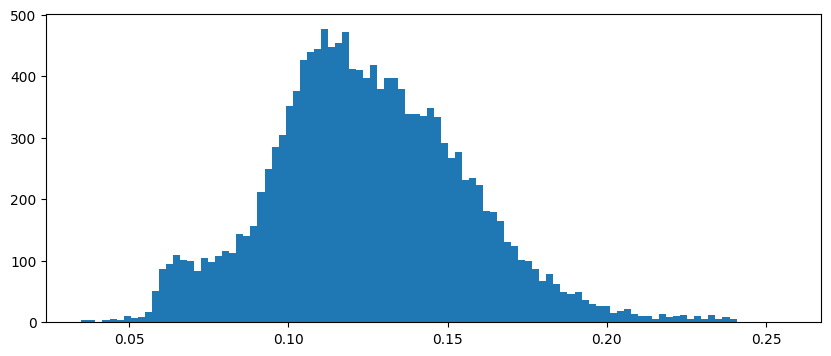

In [16]:
plt.figure(figsize=(10, 4))
plt.hist(mae_loss, bins=100)
plt.show()

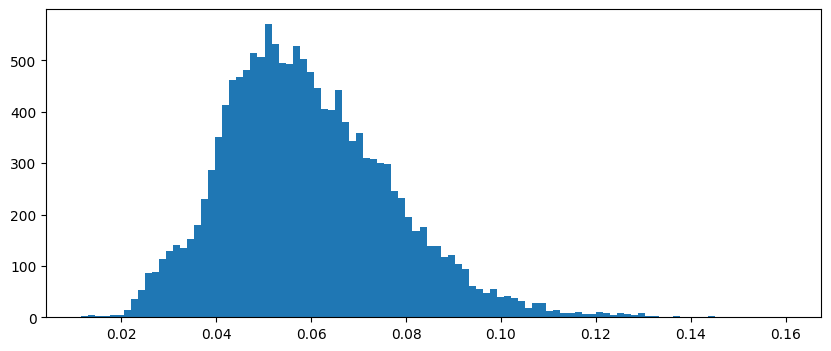

In [17]:
plt.figure(figsize=(10, 4))
plt.hist(mse_loss, bins=100)
plt.show()

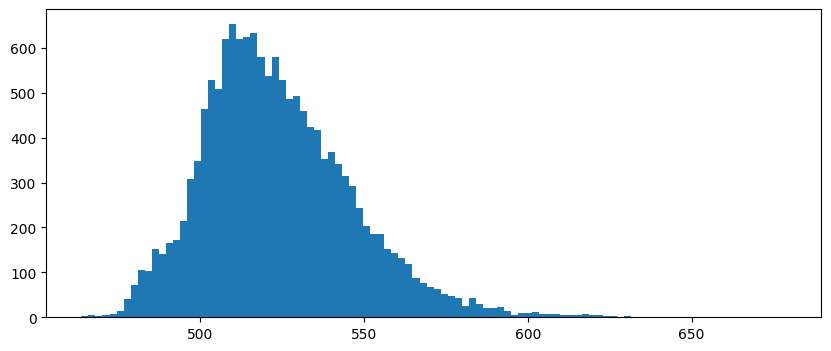

In [18]:
plt.figure(figsize=(10, 4))
plt.hist(cce_loss, bins=100)
plt.show()

The threshold value based on the mean and standard deviation of the reconstruction error. This threshold provides a reference point for distinguishing between normal reconstruction errors and potential outliers.

In [19]:
mae_threshold = np.mean(mae_loss) + 3*np.std(mae_loss)
print(mae_threshold)

tf.Tensor(0.21757996, shape=(), dtype=float32)


In [20]:
mse_threshold = np.mean(mse_loss) + 3*np.std(mse_loss)
print(mse_threshold)

tf.Tensor(0.112586334, shape=(), dtype=float32)


In [21]:
cce_threshold = np.mean(cce_loss) + 3*np.std(cce_loss)
print(cce_threshold)

tf.Tensor(592.4004, shape=(), dtype=float32)


Visualize the distribution of the reconstruction errors and highlight the threshold for identifying outliers in the reconstruction error.

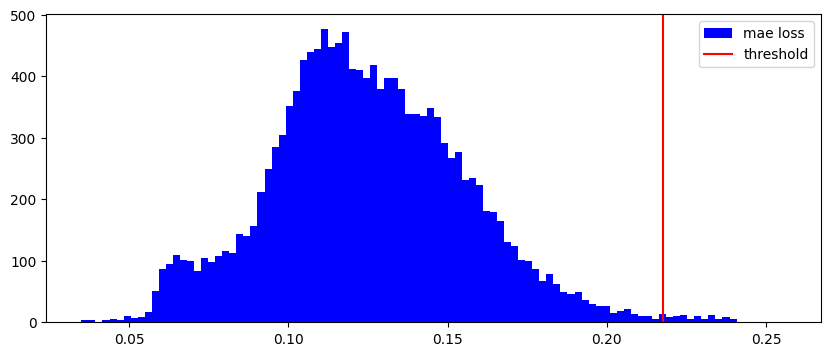

In [22]:
plt.figure(figsize=(10, 4))
plt.hist(mae_loss, bins=100, color='b', label="mae loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(mae_threshold, color='r', label="threshold")
plt.legend()
plt.show()

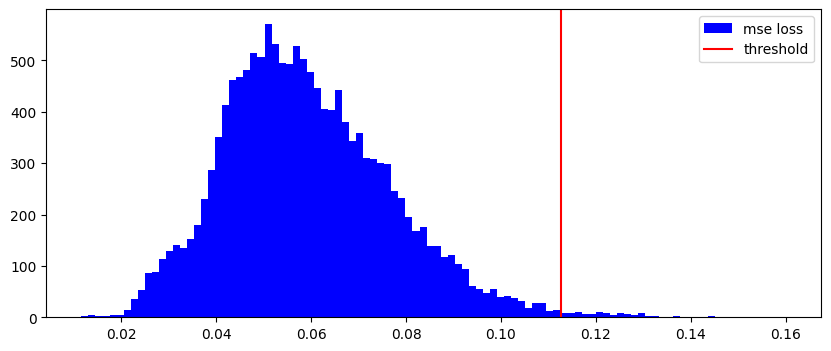

In [23]:
plt.figure(figsize=(10, 4))
plt.hist(mse_loss, bins=100, color='b', label="mse loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(mse_threshold, color='r', label="threshold")
plt.legend()
plt.show()

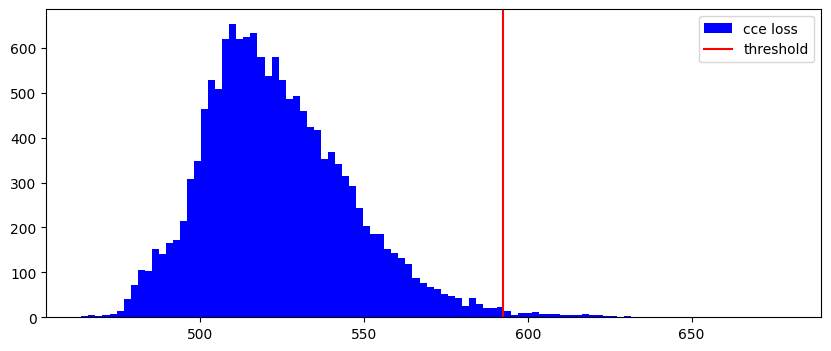

In [24]:
plt.figure(figsize=(10, 4))
plt.hist(cce_loss, bins=100, color='b', label="cce loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(cce_threshold, color='r', label="threshold")
plt.legend()
plt.show()

In [25]:
errors = pd.DataFrame()
errors['mae_error'] = mae_loss
errors['mae_rank'] = errors['mae_error'].rank(pct=True)
errors['mse_error'] = mse_loss
errors['mse_rank'] = errors['mse_error'].rank(pct=True)
errors['cce_error'] = cce_loss
errors['cce_rank'] = errors['cce_error'].rank(pct=True)

errors['error_rank'] = (errors['cce_rank'] + errors['mse_rank'] + errors['mae_rank']) / 3



<Axes: xlabel='mae_rank', ylabel='mse_rank'>

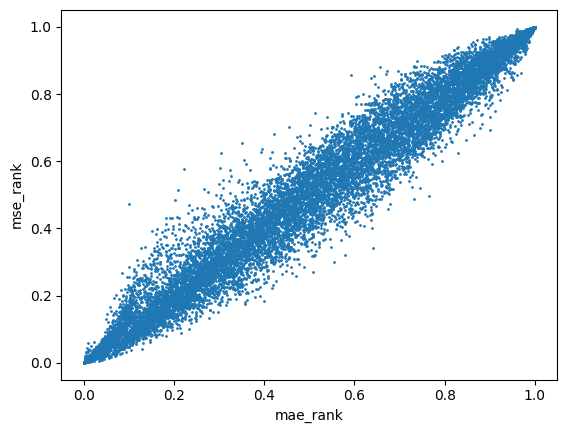

In [26]:
errors.plot(kind='scatter', x='mae_rank', y='mse_rank', s=1)

<Axes: xlabel='mse_rank', ylabel='cce_rank'>

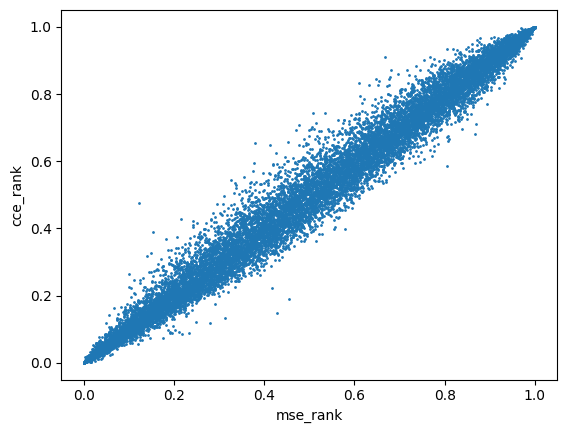

In [27]:
errors.plot(kind='scatter', x='mse_rank', y='cce_rank', s=1)

<Axes: xlabel='mae_rank', ylabel='cce_rank'>

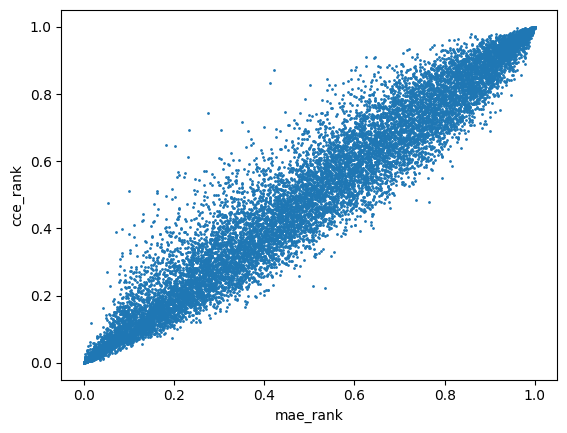

In [28]:
errors.plot(kind='scatter', x='mae_rank', y='cce_rank', s=1)

Obtain the indices in descending order of the reconstruction errors.

In [29]:
combined_df = pd.concat([vectorized_df, predicted, errors], axis=1)
combined_df = combined_df.sort_values('error_rank', ascending=False)

# Create a GCS filesystem object
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Define the path to the file on GCS
gcs_path = "gs://autoencoder_census_models/data_with_reconstructed_errors.csv"

# Save the DataFrame to GCS
with fs.open(gcs_path, 'w') as gcs_file:
    combined_df.to_csv(gcs_file)

Identify and extract a subset of samples from the original dataset that have the 100 highest reconstruction errors and have reconstruction errors exceeding the threshold value.

In [30]:
combined_df.head(20)

,age__12 years old or younger,age__13 years old,age__14 years old,age__15 years old,age__16 years old,age__17 years old,age__18 years old or older,age__nan,sex__Female,sex__Male,...,bmi_cat__top-extreme%,bmipct_cat__missing,bmipct_cat__normal,mae_error,mae_rank,mse_error,mse_rank,cce_error,cce_rank,error_rank
5822,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.027851,0.040360,0.959640,0.256151,1.000000,0.160042,1.000000,678.796936,1.000000,1.000000
5390,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.031238,0.076408,0.923592,0.247842,0.999932,0.144274,0.999932,657.032104,0.999932,0.999932
6529,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.023320,0.026189,0.973811,0.245141,0.999865,0.143966,0.999865,644.564819,0.999865,0.999865
4903,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.025175,0.036957,0.963043,0.241883,0.999797,0.138585,0.999729,643.492493,0.999797,0.999774
3139,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.033249,0.113351,0.886649,0.239684,0.999661,0.132779,0.999458,630.278503,0.999661,0.999594
7167,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.016589,0.863706,0.136294,0.240245,0.999729,0.132112,0.999323,625.211304,0.999255,0.999436
6455,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.029196,0.124985,0.875015,0.236443,0.998916,0.137272,0.999661,630.274658,0.999594,0.999390
6946,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.035200,0.157170,0.842830,0.237857,0.999255,0.131420,0.999187,629.534424,0.999526,0.999323
147,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.019645,0.015115,0.984885,0.233477,0.998307,0.141548,0.999797,641.794739,0.999729,0.999278
10686,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.030677,0.072288,0.927712,0.236259,0.998781,0.134030,0.999526,628.521362,0.999458,0.999255


In [ ]:
vectorizer.tabularize_vector(vectorized_df), vectorizer.tabularize_vector(predicted)

In [59]:
t = combined_df.query("error_rank > 0.99")['carrot_eating__4 or more times per day']
t.columns = ['correct', 'predicted']
t.correct.value_counts()


0.0    111
1.0     20
Name: correct, dtype: int64

In [60]:
t = combined_df.query("error_rank < 0.98")['carrot_eating__4 or more times per day']
t.columns = ['correct', 'predicted']
t.correct.value_counts()

0.0    14352
1.0      139
Name: correct, dtype: int64